In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [46]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [47]:
NUM_CLASSES = 23

# Dataset reading

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),

    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 30)                1290      
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 20)                620       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
 dense_10 (Dense)            (None, 23)                253       
                                                                 
Total params: 2,373
Trainable params: 2,373
Non-traina

In [53]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [55]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
60/63 [===========================>..] - ETA: 0s - loss: 3.1144 - accuracy: 0.0716
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 1s 6ms/step - loss: 3.1124 - accuracy: 0.0731 - val_loss: 3.0488 - val_accuracy: 0.1269
Epoch 2/1000
50/63 [======================>.......] - ETA: 0s - loss: 3.0052 - accuracy: 0.1055
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 4ms/step - loss: 2.9820 - accuracy: 0.1100 - val_loss: 2.8136 - val_accuracy: 0.1654
Epoch 3/1000
48/63 [=====================>........] - ETA: 0s - loss: 2.7606 - accuracy: 0.1413
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 3ms/step - loss: 2.7286 - accuracy: 0.1474 - val_loss: 2.4241 - val_accuracy: 0.2691
Epoch 4/1000
48/63 [=====================>........] - ETA: 0s - loss: 2.4457 - accura

In [56]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

21/21 [==============================] - 0s 1ms/step - loss: 0.3120 - accuracy: 0.9104


In [57]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [58]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.0000000e+00 0.0000000e+00 9.0172904e-17 0.0000000e+00 1.2760513e-20
 4.5926288e-19 3.0543666e-07 1.1198948e-06 0.0000000e+00 1.1362369e-16
 6.7165116e-25 9.9999857e-01 0.0000000e+00 0.0000000e+00 1.9810100e-09
 1.9070539e-23 0.0000000e+00 0.0000000e+00 4.4806015e-17 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
11


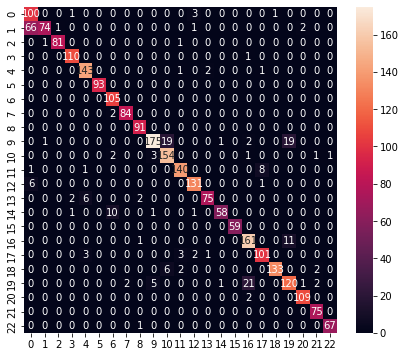

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       105
           1       0.97      0.51      0.67       144
           2       0.99      0.98      0.98        83
           3       0.96      0.99      0.98       111
           4       0.93      0.97      0.95       147
           5       1.00      1.00      1.00        93
           6       0.88      1.00      0.94       105
           7       0.98      0.98      0.98        86
           8       0.96      1.00      0.98        91
           9       0.95      0.81      0.87       217
          10       0.86      0.95      0.90       162
          11       0.95      0.93      0.94       150
          12       0.95      0.95      0.95       138
          13       0.96      0.88      0.92        85
          14       0.97      0.82      0.89        71
          15       1.00      1.00      1.00        59
          16       0.86      0.93      0.89       173
     

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [60]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [61]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Bilal\AppData\Local\Temp\tmpgo32tmun\assets


INFO:tensorflow:Assets written to: C:\Users\Bilal\AppData\Local\Temp\tmpgo32tmun\assets


8008

# Inference test

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [63]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 499 µs


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.9382608e-39 2.9382608e-39 7.6230080e-17 2.9382608e-39 1.2050753e-20
 7.1040080e-19 4.0613617e-07 1.2984664e-06 2.9382608e-39 1.7655666e-16
 1.3501687e-24 9.9999833e-01 2.9382608e-39 2.9382608e-39 2.6768980e-09
 3.8185999e-23 2.9382608e-39 2.9382608e-39 7.7650296e-17 2.9382608e-39
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
11
